# [2024 Fall AI604] Assignment 3

In this assignment, you will implement two generative models: Generative Adversarial Networks (GANs) and Diffusion models. For GANs, you will practice training the model from scratch, and for Diffusion models, you will fine-tune a pre-trained Stable Diffusion model.

**IMPORTANT**: Do not modify the code outside the implementation section.

## Part 1: Train GAN from scratch (50 points)

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms.v2 as transforms
import torchvision.datasets as datasets

In [2]:
seed = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(seed)

### Prepare dataset and model

100%|██████████| 26.4M/26.4M [00:00<00:00, 117MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 4.73MB/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw




100%|██████████| 4.42M/4.42M [00:00<00:00, 62.5MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 21.8MB/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



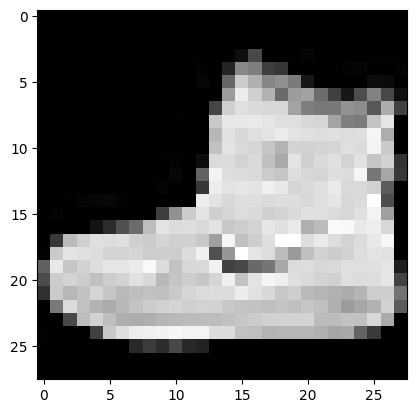

In [3]:
transform = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize((0.5,), (0.5,))
])
dataset = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform,
)

plt.imshow(dataset[0][0].squeeze(), cmap="gray")

In [4]:
class Generator(nn.Module):
    def __init__(self, latent_dim, channels, output_dim):
        super().__init__()
        self.conv1 = nn.ConvTranspose2d(latent_dim, channels*4, 4, 1, 0)
        self.conv2 = nn.ConvTranspose2d(channels*4, channels*2, 3, 2, 1)
        self.conv3 = nn.ConvTranspose2d(channels*2, channels, 4, 2, 1)
        self.conv4 = nn.ConvTranspose2d(channels, output_dim, 4, 2, 1)

    def forward(self, z):
        x = z.view(z.size(0), z.size(1), 1, 1)
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = self.conv4(x)
        return torch.tanh(x)


class Discriminator(nn.Module):
    def __init__(self, input_dim, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(input_dim, channels, 4, 2, 1)
        self.conv2 = nn.Conv2d(channels, channels*2, 4, 2, 1)
        self.conv3 = nn.Conv2d(channels*2, channels*4, 3, 2, 1)
        self.conv4 = nn.Conv2d(channels*4, 1, 4, 1, 0)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = self.conv4(x)
        x = torch.sigmoid(x)
        return x.view(x.size(0), -1)

### Training steps for GANs

In this section, you will define the training process for GANs. Optimizing GANs involves two main steps:
(1) **updating the discriminator**,
and
(2) **updating the generator**.

The loss functions for the discriminator and generator are as follows:

* **Discriminator loss:**
$$
L_D = \log D(x) + \log( 1-D(G(z)))
$$

* **Generator loss:**
$$
L_G = \log( 1-D(G(z)))
$$

To implement these loss functions, you can use [`F.binary_cross_entropy`](https://pytorch.org/docs/stable/generated/torch.nn.functional.binary_cross_entropy.html), which computes the binary cross-entropy (BCE) loss. The binary cross-entropy formula is:
$$
BCE(x, y) = \frac{1}{N} \sum^N_{i=1} y_i \log f_\theta(x_i) + (1 - y_i) \log f_\theta(x_i)
$$

where:
* $y_i$ is the target label (e.g., 1 for the real data, 0 for fake data),
* $f_\theta(x_i)$ is the model's predicted probability for input $x_i$,
* $N$ is the batch size.

In [5]:
def train_step(generator, discriminator, x_real, optimizer_g, optimizer_d):
    z = torch.randn(x_real.shape[0], z_dim, device=device)
    x_fake = generator(z)
    # Train discriminator
    ########## IMPLEMENT YOUR CODE HERE ##########
    # Train discriminator
    optimizer_d.zero_grad()

    # Discriminator's prediction for real and fake data
    d_real = discriminator(x_real)
    d_fake = discriminator(x_fake.detach())

    # Labels for real and fake data
    real_labels = torch.ones_like(d_real, device=device)
    fake_labels = torch.zeros_like(d_fake, device=device)

    # Discriminator loss
    loss_d_real = F.binary_cross_entropy(d_real, real_labels)
    loss_d_fake = F.binary_cross_entropy(d_fake, fake_labels)
    loss_d = loss_d_real + loss_d_fake

    # Backpropagate and update discriminator
    loss_d.backward()
    optimizer_d.step()
    ##############################################

    # Train generator
    ########## IMPLEMENT YOUR CODE HERE ##########
    # Train generator
    optimizer_g.zero_grad()

    # Recompute discriminator's prediction for fake data (generator wants to fool it)
    d_fake = discriminator(x_fake)

    # Generator loss
    loss_g = F.binary_cross_entropy(d_fake, real_labels)

    # Backpropagate and update generator
    loss_g.backward()
    optimizer_g.step()
    ##############################################
    return loss_g.detach(), loss_d.detach()

In [6]:
batch_size = 128  # @param {type:"integer"}
channels = 32  # @param {type:"integer"}
z_dim = 128  # @param {type:"integer"}
learning_rate = 0.0002  # @param {type:"number"}

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
)

generator = Generator(z_dim, channels, 1).to(device)
discriminator = Discriminator(1, channels).to(device)
optimizer_g = torch.optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)

### Train

In [7]:
fixed_z = torch.randn(16, z_dim, device=device)
for epoch in range(100):
    loss_g = 0
    loss_d = 0
    for x_real, y_real in dataloader:
        x_real = x_real.to(device)
        loss_g_step, loss_d_step = train_step(generator, discriminator, x_real, optimizer_g, optimizer_d)
        loss_g += loss_g_step
        loss_d += loss_d_step

    if (epoch+1) % 10 == 0:
        loss_g = (loss_g / len(dataloader)).item()
        loss_d = (loss_d / len(dataloader)).item()
        print(f"Epoch {epoch+1}: loss_g={loss_g:.4f}, loss_d={loss_d:.4f}")

Epoch 10: loss_g=1.8275, loss_d=0.7669
Epoch 20: loss_g=1.6031, loss_d=0.8583
Epoch 30: loss_g=1.5935, loss_d=0.8697
Epoch 40: loss_g=1.5582, loss_d=0.8689
Epoch 50: loss_g=1.4922, loss_d=0.9026
Epoch 60: loss_g=1.4597, loss_d=0.9078
Epoch 70: loss_g=1.4853, loss_d=0.8959
Epoch 80: loss_g=1.5028, loss_d=0.8745
Epoch 90: loss_g=1.5355, loss_d=0.8597
Epoch 100: loss_g=1.5617, loss_d=0.8493


### Generate images

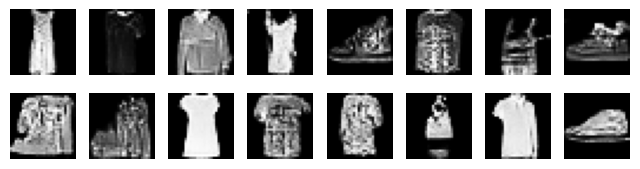

In [8]:
fixed_z = torch.randn(16, z_dim, device=device)

x_fake = generator(fixed_z).detach()
x_fake.mul_(0.5).add_(0.5).clamp_(0, 1)
plt.figure(figsize=(8, 2))
for i in range(16):
    plt.subplot(2, 8, i+1)
    plt.imshow(x_fake[i].squeeze().cpu().numpy(), cmap="gray")
    plt.axis("off")
plt.show()

In [9]:
del generator, discriminator
del optimizer_g, optimizer_d
del x_real
torch.cuda.empty_cache()

## Part 2: Fine-tune Diffusion models (50 points)

In this section, you will fine-tune a pre-trained Stable Diffusion model for text-to-image personalization. Please follow the provided guidelines to implement the code. The skeleton code is based on DreamBooth (https://arxiv.org/abs/2208.12242); however, for simplicity, we only require the use of MSE loss without prior-preservation loss.

If you encounter any difficulties with the guidelines, please refer to the DDPM (https://arxiv.org/abs/2006.11239) and LDM (https://arxiv.org/abs/2112.10752) papers.

Skeleton codes are partially borrowed from HuggingFace. Please do not copy and paste the rest of the code.

In [10]:
# Install libraries
! pip install diffusers bitsandbytes xformers

# Clone git repository for dataset
! git clone https://github.com/google/dreambooth.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 102.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Cloning into 'dreambooth'...
remote: Enumerating objects: 212, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 212 (delta 5), reused 1 (delta 1), pack-reused 206 (from 1)
Receiving objects: 100% (212/212), 106.84 MiB | 24.99 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [11]:
from accelerate import Accelerator

# Prepare accelerator
accelerator = Accelerator(
    gradient_accumulation_steps=1,
    mixed_precision="fp16",
) # Here, we use fp16 due to GPU memory constraints
print(f'device: {accelerator.device}')

device: cuda


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


### Prepare dataset and pre-trained models

In [12]:
import os
from pathlib import Path

import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
from PIL.ImageOps import exif_transpose

# Load Dataset
class DreamBoothDataset(Dataset):
    """
    Prepares the instance images with the tokenized prompts
    """
    def __init__(
        self,
        instance_data_root,
        instance_prompt,
        tokenizer,
        size=512,
        center_crop=False,
    ):
        self.size = size
        self.center_crop = center_crop
        self.tokenizer = tokenizer

        self.instance_data_root = Path(instance_data_root)
        if not self.instance_data_root.exists():
            raise ValueError(f"Instance {self.instance_data_root} images root doesn't exists.")

        self.instance_images_path = list(Path(instance_data_root).iterdir())
        self.num_instance_images = len(self.instance_images_path)
        self.instance_prompt = instance_prompt
        self._length = self.num_instance_images

        self.image_transforms = transforms.Compose(
            [
                transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.CenterCrop(size) if center_crop else transforms.RandomCrop(size),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )

    def __len__(self):
        return self._length

    def __getitem__(self, index):
        sample = {}
        instance_image = Image.open(self.instance_images_path[index % self.num_instance_images])
        instance_image = exif_transpose(instance_image)

        if not instance_image.mode == "RGB":
            instance_image = instance_image.convert("RGB")
        sample["instance_images"] = self.image_transforms(instance_image)

        text_inputs = self.tokenizer(
            self.instance_prompt,
            truncation=True,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            return_tensors="pt",
        )
        sample["instance_prompt_ids"] = text_inputs.input_ids
        sample["instance_attention_mask"] = text_inputs.attention_mask

        return sample

# Function for dataLoader
def collate_fn(examples):
    has_attention_mask = "instance_attention_mask" in examples[0]

    input_ids = [example["instance_prompt_ids"] for example in examples]
    pixel_values = [example["instance_images"] for example in examples]

    if has_attention_mask:
        attention_mask = [example["instance_attention_mask"] for example in examples]

    pixel_values = torch.stack(pixel_values)
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

    input_ids = torch.cat(input_ids, dim=0)

    batch = {
        "input_ids": input_ids,
        "pixel_values": pixel_values,
    }

    if has_attention_mask:
        attention_mask = torch.cat(attention_mask, dim=0)
        batch["attention_mask"] = attention_mask

    return batch

In [13]:
import math
import bitsandbytes as bnb
from packaging import version
from tqdm import tqdm
import xformers

from transformers import AutoTokenizer, CLIPTextModel
from diffusers import (
    AutoencoderKL,
    DDPMScheduler,
    DiffusionPipeline,
    UNet2DConditionModel,
)
from diffusers.optimization import get_scheduler

# Load models and noise scheduler
model_version = 'CompVis/stable-diffusion-v1-4'
text_encoder = CLIPTextModel.from_pretrained(
    model_version, subfolder="text_encoder", revision=None, variant=None
)
tokenizer = AutoTokenizer.from_pretrained(
    model_version,
    subfolder="tokenizer",
    revision=None,
    use_fast=False,
)
vae = AutoencoderKL.from_pretrained(
    model_version, subfolder="vae", revision=None, variant=None
)
unet = UNet2DConditionModel.from_pretrained(
    model_version, subfolder="unet", revision=None, variant=None
)
noise_scheduler = DDPMScheduler.from_pretrained(model_version, subfolder="scheduler")

# Set optimizer
optimizer_class = bnb.optim.AdamW8bit
params_to_optimize = (unet.parameters())
optimizer = optimizer_class(
    params_to_optimize,
    lr=5e-6,
    betas=(0.9, 0.999),
    weight_decay=1e-2,
    eps=1e-8,
)

# Create Dataset and DataLoaders
train_batch_size = 1  # Due to GPU memory constraints
train_dataset = DreamBoothDataset(
    instance_data_root="./dreambooth/dataset/dog",
    instance_prompt="a sks dog",
    tokenizer=tokenizer,
    size=512,
    center_crop=False,
)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
    collate_fn=lambda examples: collate_fn(examples),
    num_workers=1,
)

# Scheduler and math around the number of training steps.
num_update_steps_per_epoch = len(train_dataloader)
max_train_steps = 300
num_train_epochs = math.ceil(max_train_steps / num_update_steps_per_epoch)
print(f'num_train_epochs: {num_train_epochs}')

# Prepare models for training
unet, optimizer, train_dataloader, = accelerator.prepare(
    unet, optimizer, train_dataloader
)

vae.to(accelerator.device, dtype=torch.float16)
text_encoder.to(accelerator.device, dtype=torch.float16)

# Enable gradient checkpointing and xformers to save memory
unet.enable_gradient_checkpointing()
xformers_version = version.parse(xformers.__version__)
if xformers_version == version.parse("0.0.16"):
    assert False, "xFormers 0.0.16 cannot be used for training in some GPUs."
unet.enable_xformers_memory_efficient_attention()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

num_train_epochs: 60


### Train

#### **Implement your code with the following guideline.**
#### 1) Convert input pixel values to latent space with vae
#### 2) Sample a random timestep for each image and add noise to the model input accordingly
#### 3) Encode text prompt
#### 4) Obtain model prediction for noise
#### 5) Calculate loss (MSE loss between noises)

In [15]:
unet.train()

progress_bar = tqdm(
    range(0, max_train_steps),
    initial=0,
    desc="Steps",
)
global_step = 0

for epoch in range(0, num_train_epochs):
    for step, batch in enumerate(train_dataloader):
        with accelerator.accumulate(unet):
            # 1. Convert input pixel values to latent space
            pixel_values = batch["pixel_values"].to(accelerator.device, dtype=torch.float16)
            latents = vae.encode(pixel_values).latent_dist.sample() * 0.18215  # Scaling factor from Stable Diffusion

            # 2. Sample a random timestep and add noise
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (latents.shape[0],), device=latents.device).long()
            noise = torch.randn_like(latents)
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            # 3. Encode the text prompt
            input_ids = batch["input_ids"].to(accelerator.device)
            encoder_hidden_states = text_encoder(input_ids).last_hidden_state

            # 4. Obtain model prediction for noise
            noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

            # 5. Calculate MSE loss between predicted noise and actual noise in float32
            loss = F.mse_loss(noise_pred.float(), noise.float())


            # Backward pass and optimization step
            accelerator.backward(loss)
            if accelerator.sync_gradients:
                params_to_clip = (unet.parameters())
                accelerator.clip_grad_norm_(params_to_clip, 1.0)
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

            # Update progress and log loss
            progress_bar.update(1)
            global_step += 1
            logs = {"loss": loss.detach().item()}
            progress_bar.set_postfix(**logs)

            if global_step >= max_train_steps:
                break


Steps:   0%|          | 0/300 [00:28<?, ?it/s]

Steps: 100%|██████████| 300/300 [06:21<00:00,  1.28s/it, loss=0.0153]

### Generate image with your fine-tuned model

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

Keyword arguments {'dtype': torch.float16} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

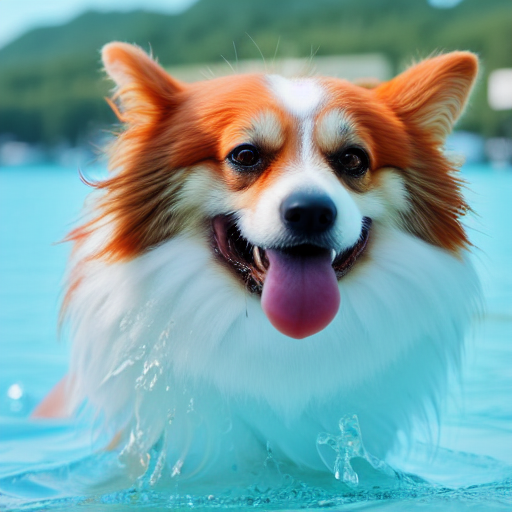

In [16]:
prompt = "a sks dog swimming in the ocean"  # @param {type:"string"}
num_inference_steps = 50  # @param {type:"integer"}
guidance_scale = 7.5  # @param {type:"number"}

pipeline = DiffusionPipeline.from_pretrained(
    model_version,
    unet=unet,
    dtype=torch.float16,
).to(accelerator.device)
pipeline.scheduler = DDPMScheduler.from_pretrained(model_version, subfolder="scheduler")
pipeline.enable_xformers_memory_efficient_attention()

image = pipeline(
    prompt=prompt,
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
).images[0]

image